# Amazon Review Analysis
In the following notebook, which is a part of the 4 part assignment, we will be implementing a model which does a sentiment analysis on a dataset using XGBoost + Word2Vec.

For the following we will be doing the following things:
1. Data Preprocessing
2. Making Data Machine Undersdtandable
3. XGBoost with Word2Vec
4. Evaluation and Plotting Graph

## Data Pre-processing


In [ ]:
# Data Preprocessing
import pandas as pd
import numpy as np
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split

# Download required NLTK data files
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

# Load the data
train_df = pd.read_csv('/content/drive/MyDrive/Machine Learning for Finances/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Machine Learning for Finances/test.csv')

# Function to clean text
def clean_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize
    tokens = nltk.word_tokenize(text.lower())
    # Remove stop words and lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)

# Apply the clean_text function to the reviewText column
train_df['cleanedText'] = train_df['reviewText'].apply(clean_text)
test_df['cleanedText'] = test_df['reviewText'].apply(clean_text)

# Separate features and target
X_train = train_df['cleanedText']
y_train = train_df['Positive']
X_test = test_df['cleanedText']
y_test = test_df['Positive']

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Making Data Machine Understandable

In [ ]:
# Unzipping Pretrained Model
#import zipfile

# Path to your zipped Word2Vec model
#zip_path = '/content/drive/MyDrive/Machine Learning for Finances/GoogleNews-vectors-negative300.bin.zip'
#extract_path = '/content/drive/MyDrive/Machine Learning for Finances/'

# Unzip the file
#with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    #zip_ref.extractall(extract_path)

In [ ]:
from gensim.models import KeyedVectors
import numpy as np

word2vec_path = '//content/drive/MyDrive/Machine Learning for Finances/GoogleNews-vectors-negative300.bin'
word2vec_model = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

def get_word2vec_features(text):
    tokens = text.split()
    vectors = [word2vec_model[word] for word in tokens if word in word2vec_model]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)

# Apply to the datasets
X_train_vectors = np.array([get_word2vec_features(text) for text in X_train])
X_test_vectors = np.array([get_word2vec_features(text) for text in X_test])

## XGBoost with Word2Vec

In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0]
}

# Initialize XGBoost model
xgb_model = xgb.XGBClassifier(device='gpu')

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid,
                                    n_iter=10, cv=3, verbose=1, n_jobs=-1, random_state=42)

# Fit RandomizedSearchCV
random_search.fit(X_train_vectors, y_train)

# Best parameters and score
print(f'Best Parameters: {random_search.best_params_}')
print(f'Best Score: {random_search.best_score_}')

# Use the best model
best_model = random_search.best_estimator_

# Predict and evaluate with the best model
y_pred = best_model.predict(X_test_vectors)
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'subsample': 0.9, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.2}
Best Score: 0.8661251044163264
              precision    recall  f1-score   support

           0       0.78      0.65      0.71       958
           1       0.89      0.94      0.92      3042

    accuracy                           0.87      4000
   macro avg       0.84      0.80      0.81      4000
weighted avg       0.87      0.87      0.87      4000



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [21:04:02] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


## Evaluation and Plotting Graph


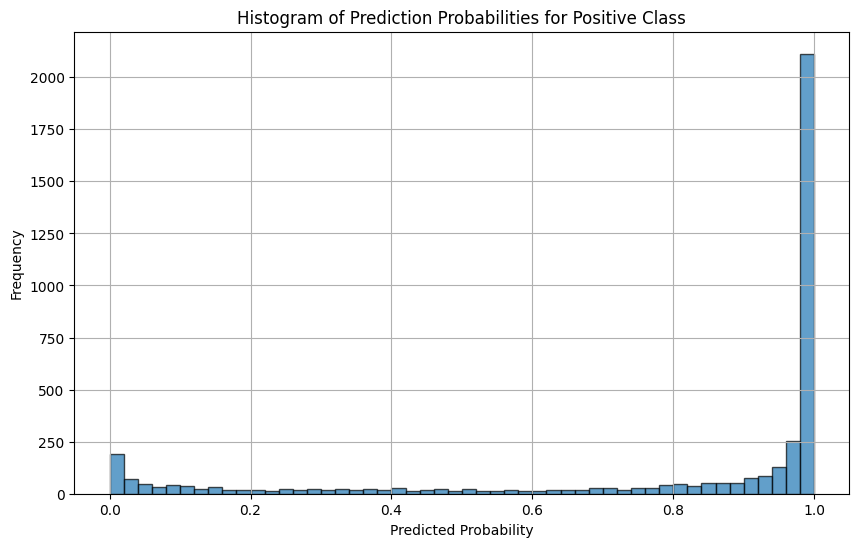

In [ ]:
import matplotlib.pyplot as plt

# Get predicted probabilities
y_pred_prob = best_model.predict_proba(X_test_vectors)[:, 1]

# Plot histogram of prediction probabilities
plt.figure(figsize=(10, 6))
plt.hist(y_pred_prob, bins=50, edgecolor='k', alpha=0.7)
plt.title('Histogram of Prediction Probabilities for Positive Class')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
# Print optimized hyperparameters
print("Optimized Hyperparameters:")
for param, value in random_search.best_params_.items():
    print(f"{param}: {value}")

Optimized Hyperparameters:
subsample: 0.9
n_estimators: 300
max_depth: 5
learning_rate: 0.2
